In [1]:
%matplotlib inline


import random

import matplotlib.pyplot as plt
import numpy as np
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Utils
def set_manual_seed(seed: int, random):
  print("Random Seed: ", seed)
  random.seed(seed)
  torch.manual_seed(seed)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')


def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()


# **CREATE DATA SET**

In [3]:
batch_size = 8
num_workers = 8

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5), std=(0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


49481264


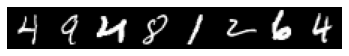

In [4]:
# Get some random training images
# set_manual_seed(999)
dataiter = iter(trainloader)
images, labels = dataiter._next_data()

# Show images
imshow(torchvision.utils.make_grid(tensor=images, nrow=batch_size, padding=False))
generated_number = ''.join([str(label.item()) for label in labels])
print(generated_number)

# TODO: save images to disk along with their label

# **TRAIN MODEL**

In [6]:
batch_size = 4
num_workers = 8

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [7]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [8]:
# Build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [9]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [10]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [11]:
# Loss
criterion = nn.BCELoss() 

# Optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [12]:
# Train the discriminator
def D_train(x):
    D.zero_grad()

    # Train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # Train discriminator on fake
    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # Gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [13]:
# Train the generator
def G_train(x):
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # Gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [14]:
# Training
checkpoint_path = './checkpoints'
best_model_path = './checkpoints/best'
epochs = 1

for epoch in range(1, epochs + 1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
    # Create checkpoint variable and add important data
    G_checkpoint = {
        'epoch': epoch + 1,
        # 'valid_loss_min': G_losses,
        'state_dict': G.state_dict(),
        'optimizer': G_optimizer.state_dict(),
    }

    D_checkpoint = {
        'epoch': epoch + 1,
        # 'valid_loss_min': D_losses,
        'state_dict': D.state_dict(),
        'optimizer': D_optimizer.state_dict()
    }

    # # Save checkpoint
    # save_ckp(G_checkpoint, False, checkpoint_path, best_model_path)
    # save_ckp(D_checkpoint, False, checkpoint_path, best_model_path)
    torch.save(G_checkpoint, checkpoint_path)
    torch.save(D_checkpoint, checkpoint_path)

[1/1]: loss_d: 0.147, loss_g: 31.238


In [ ]:
# Save image
with torch.no_grad():
    test_z = Variable(torch.randn(batch_size, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample_' + '.png')

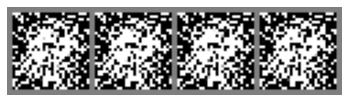

In [15]:
with torch.no_grad():
    test_z = Variable(torch.randn(batch_size, z_dim).to(device))
    generated = G(test_z)

    imshow(torchvision.utils.make_grid(generated.view(generated.size(0), 1, 28, 28)))